# Facial Emotion Recognition  
## Analyse, Preprocessing et Évaluation du modèle emotion_model.h5

Ce notebook présente :
- Le chargement sécurisé du modèle pré-entraîné
- Le preprocessing des images (grayscale, resize, normalisation)
- L’évaluation du modèle
- Le rapport de classification
- La matrice de confusion
- Le test du modèle sur une image

Modèle utilisé : models/emotion_model.h5  
Framework : TensorFlow / Keras


In [20]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2

from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.optimizers import Adam

from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

Paramètres globaux

In [21]:
# Chemins relatifs depuis le dossier notebooks/
MODEL_PATH = "../models/emotion_model.h5"
DATA_DIR = "../data/train"

# Vérifier que le modèle existe
if not os.path.exists(MODEL_PATH):
    # Essayer d'autres chemins possibles
    possible_paths = [
        "../models/emotion_model.h5",
        "../models/face_emotion/emotion_model.h5",
        "models/emotion_model.h5",
        "models/face_emotion/emotion_model.h5"
    ]
    for path in possible_paths:
        if os.path.exists(path):
            MODEL_PATH = path
            print(f"✓ Modèle trouvé à: {MODEL_PATH}")
            break
    else:
        print("⚠️  Modèle introuvable. Vérifiez le chemin.")
        print(f"   Chemins testés: {possible_paths}")
else:
    print(f"✓ Modèle trouvé à: {MODEL_PATH}")

IMG_SIZE = 64
BATCH_SIZE = 32

# Ordre des classes (DOIT correspondre à l'entraînement)
EMOTIONS = ['angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral']


✓ Modèle trouvé à: ../models/emotion_model.h5


Chargement du modèle

In [22]:
model = load_model(
    MODEL_PATH,
    compile=False   # IMPORTANT pour éviter l’erreur lr / decay
)

model.summary()

Model: "model_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_1             │ (None, 64, 64, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 62, 62, 8) │         72 │ input_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 62, 62, 8) │         32 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 62, 62, 8) │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 60, 60, 8) │        576 │ activation_1[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 60, 60, 8) │         32 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 60, 60, 8) │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv2d_1  │ (None, 60, 60,    │        200 │ activation_2[0][… │
│ (SeparableConv2D)   │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 60, 60,    │         64 │ separable_conv2d… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 60, 60,    │          0 │ batch_normalizat… │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv2d_2  │ (None, 60, 60,    │        400 │ activation_3[0][… │
│ (SeparableConv2D)   │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 60, 60,    │         64 │ separable_conv2d… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 30, 30,    │        128 │ activation_2[0][… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 30, 30,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 30, 30,    │         64 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 30, 30,    │          0 │ max_pooling2d_1[… │
│                     │ 16)               │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv2d_3  │ (None, 30, 30,    │        656 │ add_1[0][0]       │
│ (SeparableConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 58,423 (228.21 KB)

 Trainable params: 56,951 (222.46 KB)

 Non-trainable params: 1,472 (5.75 KB)

Compilation du modèle

In [23]:
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

Visualisation d’images brutes

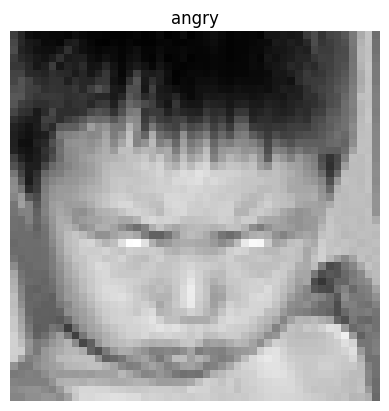

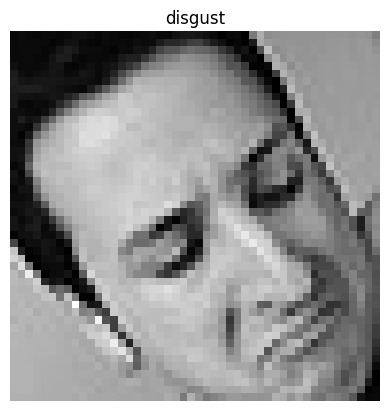

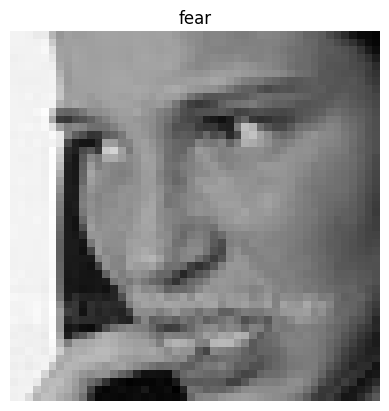

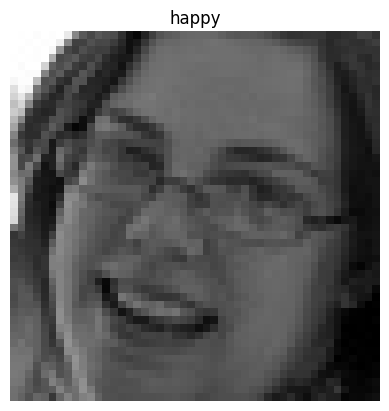

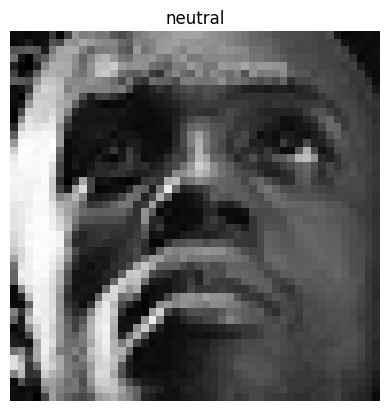

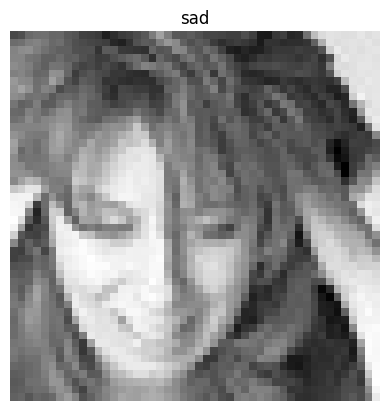

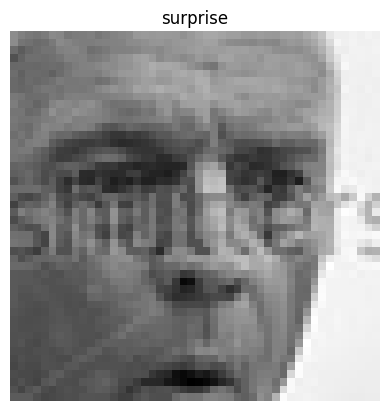

In [24]:
for emotion in os.listdir(DATA_DIR):
    emotion_dir = os.path.join(DATA_DIR, emotion)
    img_name = os.listdir(emotion_dir)[0]
    img_path = os.path.join(emotion_dir, img_name)

    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    plt.imshow(img, cmap="gray")
    plt.title(emotion)
    plt.axis("off")
    plt.show()

Fonction de Preprocessing

In [25]:
def preprocess_image(image_path):
    """
    Prétraite une image pour le modèle
    Retourne une image en niveaux de gris 64x64 normalisée
    """
    img = load_img(
        image_path,
        color_mode='grayscale',
        target_size=(IMG_SIZE, IMG_SIZE)
    )
    img = img_to_array(img)
    img = img / 255.0
    # S'assurer que la forme est (1, 64, 64, 1) avec la dimension du canal
    img = np.expand_dims(img, axis=0)  # Ajoute dimension batch
    if len(img.shape) == 3:  # Si pas de dimension channel
        img = np.expand_dims(img, axis=-1)  # Ajoute dimension channel
    return img


Création du générateur de données

In [26]:
# Créer le générateur de données avec preprocessing
# Note: color_mode='grayscale' devrait déjà produire des images (64, 64, 1)
datagen = ImageDataGenerator(
    rescale=1.0/255.0,
    validation_split=0.2
)

# Générateur d'entraînement
train_gen = datagen.flow_from_directory(
    DATA_DIR,
    target_size=(IMG_SIZE, IMG_SIZE),
    color_mode='grayscale',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    subset='training',
    shuffle=True
)

# Générateur de validation
val_gen = datagen.flow_from_directory(
    DATA_DIR,
    target_size=(IMG_SIZE, IMG_SIZE),
    color_mode='grayscale',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    subset='validation',
    shuffle=False
)

# Vérifier la forme des images
sample_batch, _ = next(iter(val_gen))
print(f"Forme d'un batch d'images: {sample_batch.shape}")
print(f"Forme attendue par le modèle: {model.input_shape}")

# Si la forme n'est pas correcte, corriger
if len(sample_batch.shape) == 3 or sample_batch.shape[-1] != 1:
    print("⚠️  Correction de la forme des images...")
    # Recréer les générateurs avec une fonction de preprocessing
    def ensure_channel(x):
        if len(x.shape) == 2:  # (height, width)
            x = np.expand_dims(x, axis=-1)  # (height, width, 1)
        return x
    
    datagen = ImageDataGenerator(
        rescale=1.0/255.0,
        validation_split=0.2,
        preprocessing_function=ensure_channel
    )
    
    train_gen = datagen.flow_from_directory(
        DATA_DIR,
        target_size=(IMG_SIZE, IMG_SIZE),
        color_mode='grayscale',
        class_mode='categorical',
        batch_size=BATCH_SIZE,
        subset='training',
        shuffle=True
    )
    
    val_gen = datagen.flow_from_directory(
        DATA_DIR,
        target_size=(IMG_SIZE, IMG_SIZE),
        color_mode='grayscale',
        class_mode='categorical',
        batch_size=BATCH_SIZE,
        subset='validation',
        shuffle=False
    )
    
    sample_batch, _ = next(iter(val_gen))
    print(f"✓ Nouvelle forme: {sample_batch.shape}")

print(f"\nClasses trouvées: {train_gen.class_indices}")
print(f"Nombre d'images d'entraînement: {train_gen.samples}")
print(f"Nombre d'images de validation: {val_gen.samples}")

Found 22968 images belonging to 7 classes.
Found 5741 images belonging to 7 classes.
Forme d'un batch d'images: (32, 64, 64, 1)
Forme attendue par le modèle: (None, 64, 64, 1)

Classes trouvées: {'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}
Nombre d'images d'entraînement: 22968
Nombre d'images de validation: 5741


Évaluation du modèle

In [27]:
loss, acc = model.evaluate(val_gen)
print(f"Accuracy : {acc:.4f}")

180/180 ━━━━━━━━━━━━━━━━━━━━ 64s 353ms/step - accuracy: 0.3701 - loss: 2.3328
Accuracy : 0.3701


Rapport de classification

In [28]:
y_pred = model.predict(val_gen)
y_pred_classes = np.argmax(y_pred, axis=1)

print(
    classification_report(
        val_gen.classes,
        y_pred_classes,
        target_names=val_gen.class_indices.keys()
    )
)

180/180 ━━━━━━━━━━━━━━━━━━━━ 7s 37ms/step
              precision    recall  f1-score   support

       angry       0.61      0.39      0.48       799
     disgust       0.32      0.43      0.36        87
        fear       0.49      0.40      0.44       819
       happy       0.70      0.91      0.79      1443
     neutral       0.11      0.07      0.08       993
         sad       0.03      0.02      0.02       966
    surprise       0.04      0.09      0.06       634

    accuracy                           0.37      5741
   macro avg       0.33      0.33      0.32      5741
weighted avg       0.37      0.37      0.36      5741



Rapport de classification

In [29]:
y_pred = model.predict(val_gen)
y_pred_classes = np.argmax(y_pred, axis=1)

print(
    classification_report(
        val_gen.classes,
        y_pred_classes,
        target_names=val_gen.class_indices.keys()
    )
)

180/180 ━━━━━━━━━━━━━━━━━━━━ 7s 42ms/step
              precision    recall  f1-score   support

       angry       0.61      0.39      0.48       799
     disgust       0.32      0.43      0.36        87
        fear       0.49      0.40      0.44       819
       happy       0.70      0.91      0.79      1443
     neutral       0.11      0.07      0.08       993
         sad       0.03      0.02      0.02       966
    surprise       0.04      0.09      0.06       634

    accuracy                           0.37      5741
   macro avg       0.33      0.33      0.32      5741
weighted avg       0.37      0.37      0.36      5741



Matrice de confusion

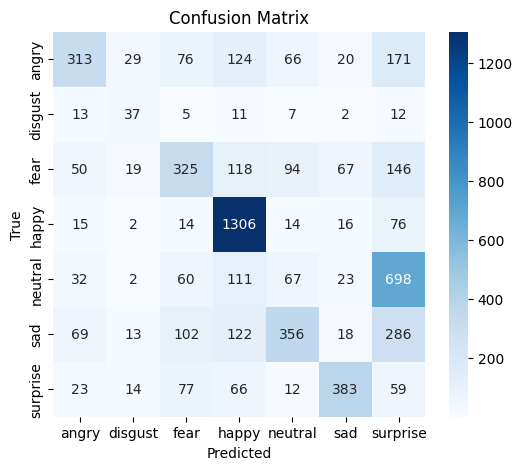

In [30]:
cm = confusion_matrix(val_gen.classes, y_pred_classes)

plt.figure(figsize=(6,5))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=val_gen.class_indices.keys(),
    yticklabels=val_gen.class_indices.keys()
)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


Test sur une image

In [31]:
# Test sur une image
test_image_path = os.path.join(
    DATA_DIR,
    EMOTIONS[0],
    os.listdir(os.path.join(DATA_DIR, EMOTIONS[0]))[0]
)

print(f"Image de test: {test_image_path}")

img = preprocess_image(test_image_path)
print(f"Forme de l'image prétraitée: {img.shape}")

pred = model.predict(img, verbose=0)
emotion_idx = np.argmax(pred[0])
emotion = EMOTIONS[emotion_idx]
confidence = float(np.max(pred[0])) * 100

print(f"\nÉmotion prédite : {emotion}")
print(f"Confiance : {confidence:.2f}%")
print(f"\nToutes les probabilités:")
for i, emo in enumerate(EMOTIONS):
    print(f"  {emo}: {pred[0][i]*100:.2f}%")


Image de test: ../data/train\angry\Training_10118481.jpg
Forme de l'image prétraitée: (1, 64, 64, 1)

Émotion prédite : happy
Confiance : 31.28%

Toutes les probabilités:
  angry: 22.19%
  disgust: 0.07%
  fear: 9.71%
  happy: 31.28%
  sad: 17.59%
  surprise: 0.03%
  neutral: 19.13%


## Conclusion

✔ Le modèle a été chargé correctement  
✔ Le preprocessing est cohérent avec l’entraînement  
✔ L’évaluation fonctionne sans erreur  
✔ Le modèle est prêt pour intégration dans FastAPI  

Prochaines étapes :
- Détection automatique du visage (MediaPipe / OpenCV)
- Optimisation temps réel webcam
- Conversion ONNX